In [1]:
import numpy as np
import gymnasium as gym
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.algorithms.rl import RL
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
import seaborn as sns
import matplotlib.pyplot as plt
import random

C:\Users\hubin\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Planner(Planner):  # Extending the existing Planner class
    def value_iteration(self, gamma=1.0, n_iters=1000, theta=1e-10):
        """
        Perform value iteration algorithm on the MDP.

        Parameters:
        - gamma (float): Discount factor.
        - n_iters (int): Maximum number of iterations.
        - theta (float): Convergence threshold.

        Returns:
        - V (numpy array): The final value function.
        - V_track (numpy array): Log of value function at each iteration.
        - pi (dict): Optimal policy.
        - i (int): The number of iterations performed.
        """
        V = np.zeros(len(self.P), dtype=np.float64)
        V_track = np.zeros((n_iters, len(self.P)), dtype=np.float64)
        i = 0
        converged = False

        while i < n_iters - 1 and not converged:
            i += 1  # Increment the iteration count at the start of the loop
            Q = np.zeros((len(self.P), len(self.P[0])), dtype=np.float64)

            for s in range(len(self.P)):
                for a in range(len(self.P[s])):
                    for prob, next_state, reward, done in self.P[s][a]:
                        Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))

            max_delta = np.max(np.abs(V - np.max(Q, axis=1)))
            if max_delta < theta:
                converged = True
            V = np.max(Q, axis=1)
            V_track[i] = V  # Store the value function at each iteration

        if not converged:
            warnings.warn("Max iterations reached before convergence. Check theta and n_iters.")

        pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
        return V, V_track, pi, i  # Return the number of iterations performed as part of the output
    
    def policy_iteration(self, gamma=1.0, n_iters=50, theta=1e-10):
        """
        PARAMETERS:

        gamma {float}:
            Discount factor

        n_iters {int}:
            Number of iterations

        theta {float}:
            Convergence criterion for policy evaluation.
            State values are considered to be converged when the maximum difference between new and previous state
            values is less than theta.


        RETURNS:

        V {numpy array}, shape(possible states):
            State values array

        V_track {numpy array}, shape(n_episodes, nS):
            Log of V(s) for each iteration

        pi {lambda}, input state value, output action value:
            Policy mapping states to actions.
        """
        random_actions = np.random.choice(tuple(self.P[0].keys()), len(self.P))

        pi = {s: a for s, a in enumerate(random_actions)}
        # initial V to give to `policy_evaluation` for the first time
        V = np.zeros(len(self.P), dtype=np.float64)
        V_track = np.zeros((n_iters, len(self.P)), dtype=np.float64)
        i = 0
        converged = False
        while i < n_iters-1 and not converged:
            #print(i)
            i += 1
            old_pi = pi
            V = self.policy_evaluation(pi, V, gamma, theta)
            V_track[i] = V
            pi = self.policy_improvement(V, gamma)
            if old_pi == pi:
                converged = True
        if not converged:
            warnings.warn("Max iterations reached before convergence.  Check n_iters.")
        return V, V_track, pi, i
    
    def policy_evaluation(self, pi, prev_V, gamma=1.0, theta=1e-10):
        
        iteration = 0
        while True:
            V = np.zeros(len(self.P), dtype=np.float64)
            for s in range(len(self.P)):
                for prob, next_state, reward, done in self.P[s][pi[s]]:
                    V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
            
            delta = np.max(np.abs(prev_V - V))
            #print(f"Evaluation iteration {iteration}, max delta {delta}")
            if delta < theta:
                break
            prev_V = V.copy()
            iteration += 1
            if iteration >= 1000:
                break
        return V

    def policy_improvement(self, V, gamma=1.0):
        Q = np.zeros((len(self.P), len(self.P[0])), dtype=np.float64)
        for s in range(len(self.P)):
            for a in range(len(self.P[s])):
                for prob, next_state, reward, done in self.P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))

        new_pi = {s: a for s, a in enumerate(np.argmax(Q, axis=1))}
        #print(f"Policy improved: {sum(new_pi[s] != pi[s] for s in pi)} changes made.")
        return new_pi

In [3]:
# Assuming Planner and BlackjackWrapper are correctly implemented and imported
base_env_blackjack = gym.make('Blackjack-v1', render_mode=None)
blackjack = BlackjackWrapper(base_env_blackjack)

base_env_taxi = gym.make('Taxi-v3', render_mode=None)

# Running algorithms for Blackjack
V_vi_blackjack, V_track_vi_blackjack, pi_vi_blackjack, iter_count_vi_blackjack = Planner(blackjack.P).value_iteration()
V_pi_blackjack, V_track_pi_blackjack, pi_pi_blackjack, iter_count_po_blackjack = Planner(blackjack.P).policy_iteration()

# Running algorithms for Taxi
V_vi_taxi, V_track_vi_taxi, pi_vi_taxi, iter_count_vi_taxi = Planner(base_env_taxi.P).value_iteration()
V_pi_taxi, V_track_pi_taxi, pi_pi_taxi, iter_count_po_taxi = Planner(base_env_taxi.P).policy_iteration()

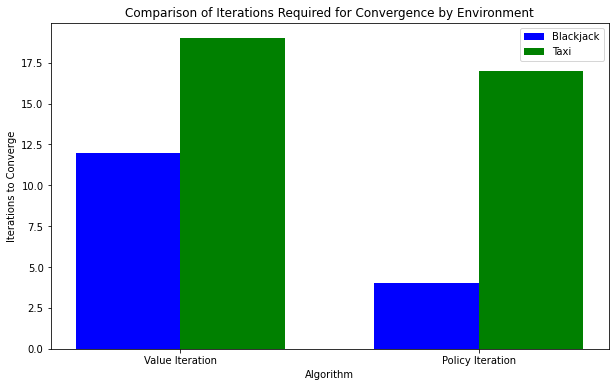

In [4]:
iterations_blackjack = [iter_count_vi_blackjack, iter_count_po_blackjack]  # [100, 80]
iterations_taxi = [iter_count_vi_taxi, iter_count_po_taxi]  # [200, 150]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)  # Two algorithms: Value Iteration and Policy Iteration
plt.bar(index, iterations_blackjack, bar_width, label='Blackjack', color='blue')
plt.bar(index + bar_width, iterations_taxi, bar_width, label='Taxi', color='green')

plt.xlabel('Algorithm')
plt.ylabel('Iterations to Converge')
plt.title('Comparison of Iterations Required for Convergence by Environment')
plt.xticks(index + bar_width / 2, ['Value Iteration', 'Policy Iteration'])
plt.legend()
plt.show()

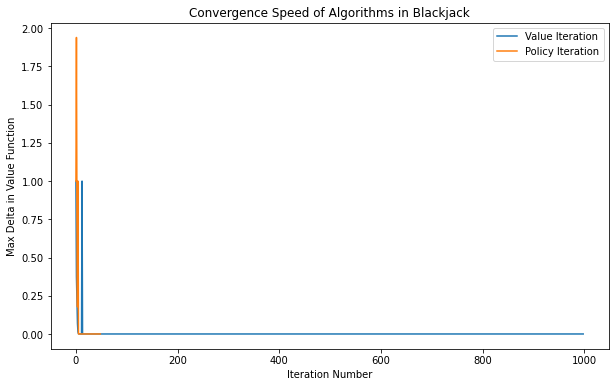

In [6]:
# Plot for Blackjack - Convergence Speed
plt.figure(figsize=(10, 6))
# Value Iteration - Max delta per iteration
plt.plot(np.max(np.abs(np.diff(V_track_vi_blackjack, axis=0)), axis=1), label='Value Iteration')
# Policy Iteration - Max delta per iteration
plt.plot(np.max(np.abs(np.diff(V_track_pi_blackjack, axis=0)), axis=1), label='Policy Iteration')

plt.xlabel('Iteration Number')
plt.ylabel('Max Delta in Value Function')
plt.title('Convergence Speed of Algorithms in Blackjack')
plt.legend()
plt.show()

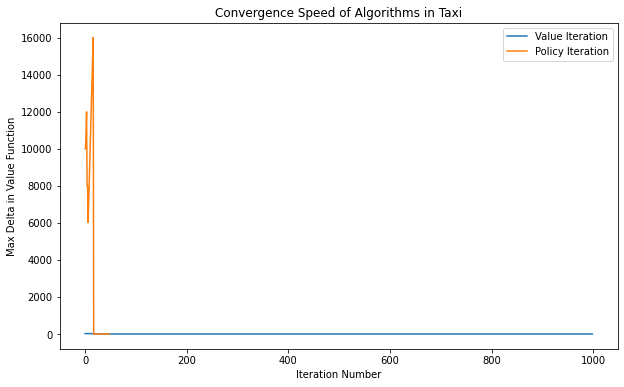

In [7]:
# Plot for Taxi - Convergence Speed
plt.figure(figsize=(10, 6))
# Value Iteration - Max delta per iteration
plt.plot(np.max(np.abs(np.diff(V_track_vi_taxi, axis=0)), axis=1), label='Value Iteration')
# Policy Iteration - Max delta per iteration
plt.plot(np.max(np.abs(np.diff(V_track_pi_taxi, axis=0)), axis=1), label='Policy Iteration')

plt.xlabel('Iteration Number')
plt.ylabel('Max Delta in Value Function')
plt.title('Convergence Speed of Algorithms in Taxi')
plt.legend()
plt.show()

In [35]:
import gym

def epsilon_greedy_policy(Q, state, nA, epsilon):
    
    if np.random.rand() > epsilon:
        return np.argmax(Q[state])
    else:
        return np.random.choice(nA)

def q_learning(env, num_episodes, alpha, gamma, epsilon):

    nA = env.action_space.n
    Q = {state: np.zeros(nA) for state in range(env.observation_space.n)}
    
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)

    for i_episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        length = 0

        while not done:
            action = epsilon_greedy_policy(Q, state, nA, epsilon)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            length += 1

            # Update Q-table using the Q-learning formula
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            state = next_state

        episode_rewards[i_episode] = total_reward
        episode_lengths[i_episode] = length

    return Q, episode_lengths, episode_rewards

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
num_episodes = 1000

# Environment setup
env_taxi = gym.make('Taxi-v3')

# Training using Q-learning
Q_taxi, lengths_taxi, rewards_taxi = q_learning(env_taxi, num_episodes, alpha, gamma, epsilon)

In [36]:
def epsilon_greedy_policy(Q, state, nA, epsilon):
    """
    Create an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    if random.random() > epsilon:  # Exploit action with max value
        return np.argmax(Q.get(state, np.zeros(nA)))
    else:  # Explore random action
        return random.choice(range(nA))

def q_learning(env, num_episodes, alpha, gamma, epsilon):
    """
    Implements the Q-learning algorithm.
    """
    nA = env.action_space.n
    Q = {}

    episode_lengths = []
    episode_rewards = []

    for i_episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, dict):
            state = tuple(state.values())
        else:
            state = tuple(state)

        total_reward = 0
        steps = 0

        while True:
            action = epsilon_greedy_policy(Q, state, nA, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = tuple(next_state)

            # Update Q-table using the Bellman equation
            best_next_action = np.argmax(Q.get(next_state, np.zeros(nA)))
            td_target = reward + gamma * Q.get(next_state, np.zeros(nA))[best_next_action]
            td_delta = td_target - Q.get(state, np.zeros(nA))[action]
            Q.setdefault(state, np.zeros(nA))[action] += alpha * td_delta

            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        episode_lengths.append(steps)
        episode_rewards.append(total_reward)

    return Q, episode_lengths, episode_rewards

# Set up environments
env_blackjack = gym.make('Blackjack-v0')

# Set parameters
num_episodes = 1000
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# Run Q-learning algorithm
Q_blackjack, lengths_blackjack, rewards_blackjack = q_learning(env_blackjack, num_episodes, alpha, gamma, epsilon)

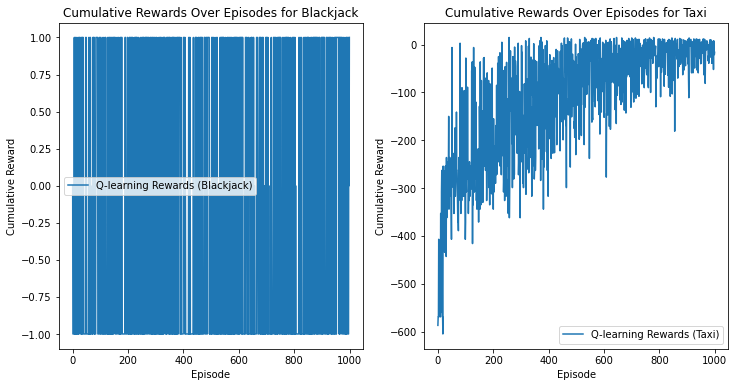

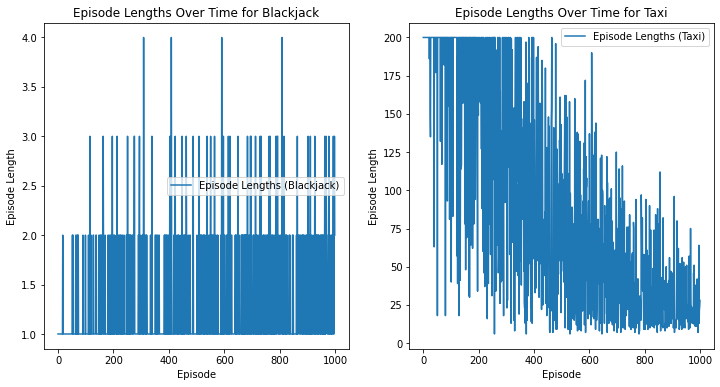

In [37]:
# Training using Q-learning
Q_taxi, lengths_taxi, rewards_taxi = q_learning(env_taxi, num_episodes, alpha, gamma, epsilon)
# Run Q-learning algorithm
Q_blackjack, lengths_blackjack, rewards_blackjack = q_learning(env_blackjack, num_episodes, alpha, gamma, epsilon)

# Plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rewards_blackjack, label='Q-learning Rewards (Blackjack)')
plt.title('Cumulative Rewards Over Episodes for Blackjack')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rewards_taxi, label='Q-learning Rewards (Taxi)')
plt.title('Cumulative Rewards Over Episodes for Taxi')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

# Plot episode lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lengths_blackjack, label='Episode Lengths (Blackjack)')
plt.title('Episode Lengths Over Time for Blackjack')
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lengths_taxi, label='Episode Lengths (Taxi)')
plt.title('Episode Lengths Over Time for Taxi')
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.legend()
plt.show()